# Setup

In [ ]:
!pip install matplotlib plotly

In [ ]:
!pip install torch torchvision opencv-python timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

# Experiment 1 (Unsuccessful)

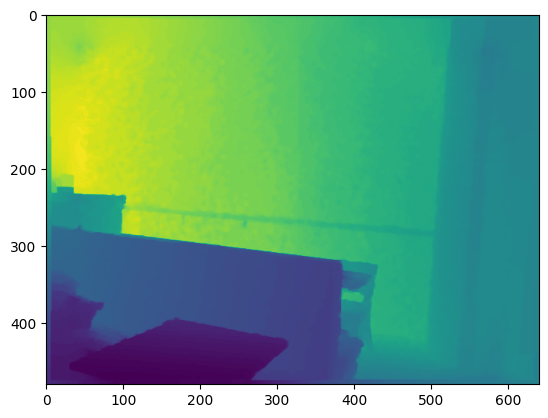

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load and normalize the depth map
def load_depth_map(path):
    depth_map = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    depth_map = cv2.normalize(depth_map, None, 0.0, 1.0, cv2.NORM_MINMAX)
    return depth_map

depth_map_path = '/content/drive/MyDrive/Capstone/NYU/data/cafe_0001a_out/1.png'
depth_map = load_depth_map(depth_map_path)

plt.imshow(depth_map)
plt.show()

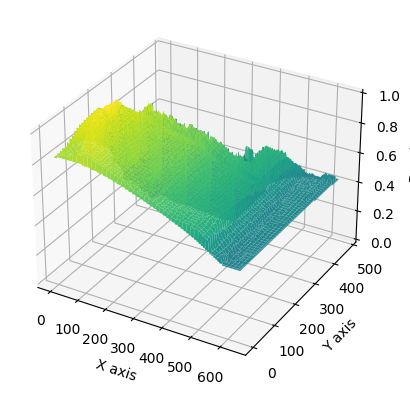

In [ ]:
def plot_3d_surface(depth_map, light_pos=(0, 0, 1)):
    height, width = depth_map.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)
    z = depth_map

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Depth')

    plt.show()

plot_3d_surface(depth_map)

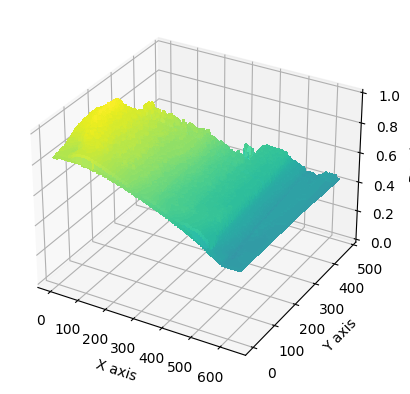

In [ ]:
from matplotlib import cm
from matplotlib.colors import LightSource

def plot_3d_surface_with_light(depth_map, light_pos=(1, 1, 10)):
    height, width = depth_map.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)
    z = depth_map

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ls = LightSource(azdeg=light_pos[0], altdeg=light_pos[1])
    rgb = ls.shade(z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')

    ax.plot_surface(x, y, z, facecolors=rgb, rstride=1, cstride=1, antialiased=False, shade=False)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Depth')

    plt.show()

# Updated light position
plot_3d_surface_with_light(depth_map, light_pos=(0, 0))

In [ ]:
# Can't find a way to re-apply the 2D image's colors to the 3D model with updated lighting.

# Experiment 2 (Unsuccessful)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize the depth map
def load_depth_map(path):
    depth_map = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    depth_map = cv2.normalize(depth_map, None, 0.0, 1.0, cv2.NORM_MINMAX)
    return depth_map

# Compute the gradient of the depth map to simulate light and shadow
def compute_lighting_effects(depth_map, light_pos):
    gx, gy = np.gradient(depth_map)
    light_dir = np.array(light_pos) / np.linalg.norm(light_pos)
    lighting = gx * light_dir[0] + gy * light_dir[1] - light_dir[2]
    lighting = (lighting - np.min(lighting)) / (np.max(lighting) - np.min(lighting))
    return lighting

# Apply the computed lighting to the original image
def apply_lighting_to_image(image_path, lighting):
    image = cv2.imread(image_path)
    lighting = cv2.normalize(lighting, None, 0, 1, cv2.NORM_MINMAX)  # Normalize lighting effect
    lighting = np.expand_dims(lighting, axis=2)
    shadowed_image = (image.astype(np.float32) * lighting).astype(np.uint8)
    return shadowed_image

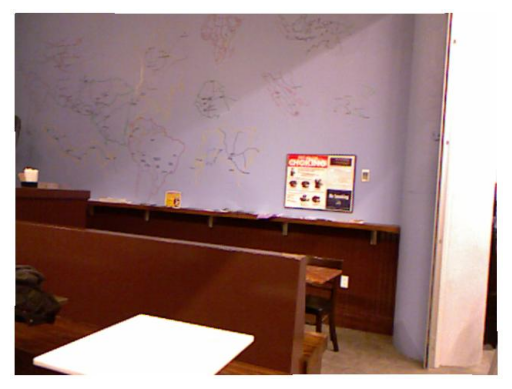

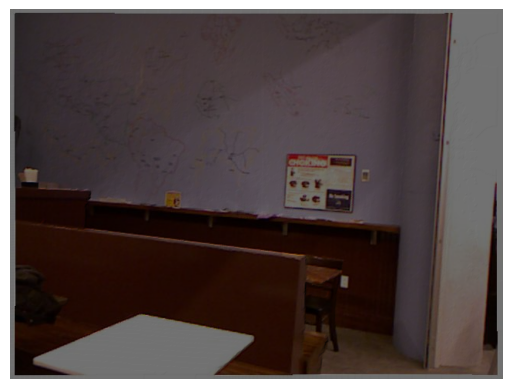

In [ ]:
# First, trying the code with an existing depth map
depth_map_path = '/content/drive/MyDrive/Capstone/NYU/data/cafe_0001a_out/1.png'
image_path = '/content/drive/MyDrive/Capstone/NYU/data/cafe_0001a_out/1.jpg'

depth_map = load_depth_map(depth_map_path)
light_dir = np.array([-1, -1, -1]) # Light direction (x,y,z)
lighting = compute_lighting_effects(depth_map, light_dir)
shadowed_image = apply_lighting_to_image(image_path, lighting)

# Original image
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# New image
plt.imshow(cv2.cvtColor(shadowed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# Generating depth map using MiDaS and checking with available altered shadowfree images
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the MiDaS model
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Load transforms to resize and normalize the image
transform = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transform.dpt_transform

# Function to generate depth map
def predict_depth(image_path, midas, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    original_size = img.size
    img = np.array(img)
    img = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(img)

        # Resize to original dimensions
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original_size[::-1],  # (height, width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


torch.Size([1, 3, 384, 384])


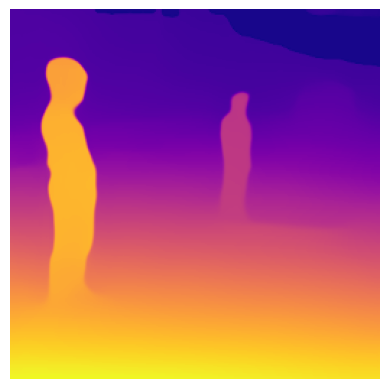

In [ ]:
# Generate depth map for the shadow-free image
image_path = '/content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/57_1.jpg'
depth_map = predict_depth(image_path, midas, transform)

# Normalize and display the depth map
depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(depth_map, cmap='plasma')
plt.axis('off')
plt.show()

In [ ]:
# Detect light source - we will recast this same light source and compare with shadowed image
def detect_light_source(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(image)
    return max_loc

# Function to get (x, y, z) coordinates of the light source
def get_light_source_coordinates(image_path, depth_map):
    x, y = detect_light_source(image_path)
    z = depth_map[y, x]
    return (x, y, z)

light_source_position = get_light_source_coordinates(image_path, depth_map)
print("Detected light source position:", light_source_position)

Detected light source position: (194, 88, 52)


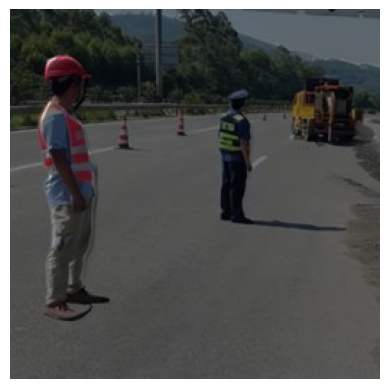

In [ ]:
lighting = compute_lighting_effects(depth_map, light_source_position)
shadowed_image = apply_lighting_to_image(image_path, lighting)

plt.imshow(cv2.cvtColor(shadowed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

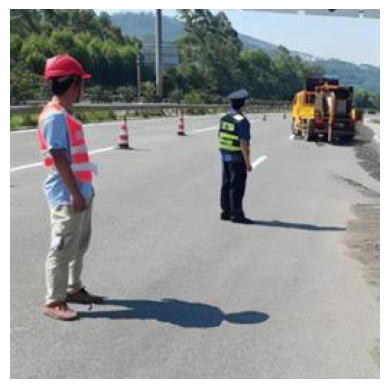

In [ ]:
# Original image
plt.imshow(cv2.cvtColor(cv2.imread('/content/drive/MyDrive/Capstone/shadow_altered/true/57_1.jpg'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Experiment 3 (Unsuccessful)

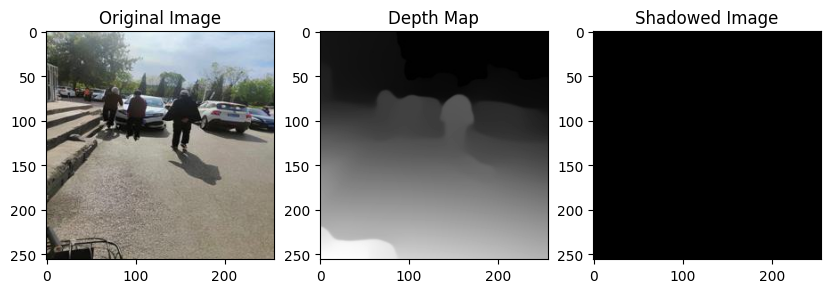

In [ ]:
# Generate shadows by tracing each ray to light source in the depth map

import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/1287_1.jpg"
depth_map_path = "/content/drive/MyDrive/Capstone/shadow_altered/depth_maps/1287_1.jpg"

original_image = cv2.imread(image_path)
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
depth_map = depth_map / 255.0

def generate_shadows(image, depth_map, light_position):
    h, w = depth_map.shape
    shadows = np.zeros_like(depth_map)

    light_dir = np.array(light_position)
    light_dir = light_dir / np.linalg.norm(light_dir)

    # For each pixel in the depth map
    for y in range(h):
        for x in range(w):
            current_depth = depth_map[y, x]
            shadow_intensity = 0

            # Trace the light ray back to the light source
            for t in range(1, 100):
                new_x = int(x + t * light_dir[0])
                new_y = int(y + t * light_dir[1])
                if new_x >= w or new_x < 0 or new_y >= h or new_y < 0:
                    break

                # Compare depth values
                if depth_map[new_y, new_x] < current_depth - t * light_dir[2] / 100:
                    shadow_intensity = 1
                    break

            shadows[y, x] = shadow_intensity

    # Create the shadow effect
    shadow_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    shadow_image = (shadow_image * (1 - shadows)).astype(np.uint8) * 255
    shadow_image = cv2.cvtColor(shadow_image, cv2.COLOR_GRAY2BGR)

    return shadow_image

light_position = [300, 300, 300]  # Light source direction

# Generate shadowed image
shadow_image = generate_shadows(original_image, depth_map, light_position)
output_path = "shadowed_image.png"
cv2.imwrite(output_path, shadow_image)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Depth Map")
plt.imshow(depth_map, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Shadowed Image")
plt.imshow(cv2.cvtColor(shadow_image, cv2.COLOR_BGR2RGB))
plt.show()

# Experiment 4 (Need to be done locally for OpenGL support) - Unsuccessful - Need to use an actual 3D modeling tool like Blender for best results

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the MiDaS model
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Load transforms to resize and normalize the image
transform = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transform.dpt_transform

# Function to generate depth map
def predict_depth(image_path, output_path, midas, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    original_size = img.size
    img = np.array(img)
    img = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(img)

        # Resize to original dimensions
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original_size[::-1],  # (height, width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    cv2.imwrite(output_path, depth_map)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:13<00:00, 100MB/s] 
Using cache found in /root/.cache/torch/hub/intel-isl_MiDa

In [ ]:
import os

input_dir = "/content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/"
output_dir = "/content/drive/MyDrive/Capstone/shadow_altered/depth_maps/"

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"{filename}")
        predict_depth(input_path, output_path, midas, transform)
        print(f"Processed {input_path} -> {output_path}")

Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/19_1.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/19_1.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/19_0.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/19_0.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/57_2.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/57_2.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/57_1.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/57_1.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/93_0.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/93_0.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/93_1.jpg -> /content/drive/MyDrive/Capstone/shadow_altered/depth_maps/93_1.jpg
Processed /content/drive/MyDrive/Capstone/shadow_altered/shadow_altered/280_2.jpg -> /content/

In [ ]:
# Locally render into 3D space and control lighting/shadow - file attached: unsuccessful_opengl_alter_lighting.py
# Unsuccessful as OpenGL doesn't provide the power to generate high quality 3D models that can be altered easily.

# The issue could be the resolution of images. Next attempt: Use Blender and high-resolution images from SOBAv2.

# Experiment 5 (Using higher resolution images + Blender) - The shadows are not great

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the MiDaS model
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Load transforms to resize and normalize the image
transform = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transform.dpt_transform

# Function to generate depth map
def predict_depth(image_path, output_path, midas, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    original_size = img.size
    img = np.array(img)
    img = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(img)

        # Resize to original dimensions
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original_size[::-1],  # (height, width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    cv2.imwrite(output_path, depth_map)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:17<00:00, 76.8MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDa

In [ ]:
import os

input_dir = "/content/drive/MyDrive/Capstone/SOBA-high-res/"
output_dir = "/content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/"

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"{filename}")
        predict_depth(input_path, output_path, midas, transform)
        print(f"Processed {input_path} -> {output_path}")

Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow01.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow01.jpg
Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow02.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow02.jpg
Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow022.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow022.jpg
Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow025.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow025.jpg
Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow07.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow07.jpg
Processed /content/drive/MyDrive/Capstone/SOBA-high-res/challenge-shadow08.jpg -> /content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow08.jpg


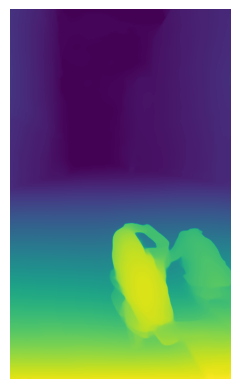

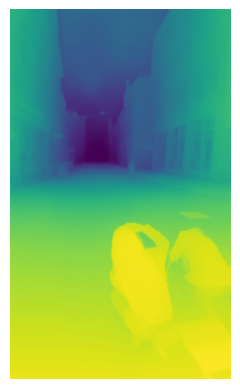

In [ ]:
# We can generate high resolution depth maps by splitting the image into tiles and combining them again.
# This has been done in a different paper by ZoeDepth (ZoeDepth v2 notebook)
# The comparison is shown below.

image_path = '/content/drive/MyDrive/Capstone/SOBA-high-res/low_depth_maps/challenge-shadow01.jpg'
high_res_path = '/content/drive/MyDrive/Capstone/SOBA-high-res/high_depth_maps/challenge-shadow01.png'

# Low-res depth image
low_res_depth_map = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
low_res_depth_map = cv2.normalize(low_res_depth_map, None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(low_res_depth_map)
plt.axis('off')
plt.show()

# High-res tiled depth image
high_res_depth_map = cv2.imread(high_res_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
high_res_depth_map = cv2.normalize(high_res_depth_map, None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(high_res_depth_map)
plt.axis('off')
plt.show()

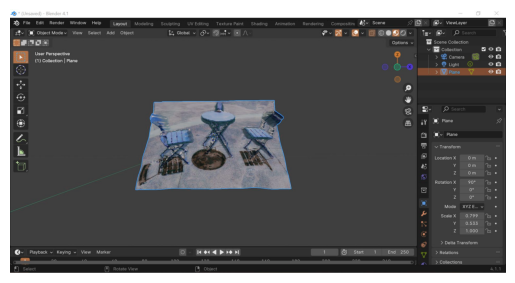

In [7]:
# Blender steps - done locally
# 1. Open Blender and create a blank project (remove cube).
# 2. Create a plane mesh and resize to height and width of image.
# 3. Go to Modeling Tab - Right click on mesh - Subdivide into 100 cuts for smoother render
# 4. Add Modifier - Displace. Select Depth Map as Image for displacement.
# 5. Add Modifier - Subdivision.
# 6. Add Material - Go to Shading tab - Import original image as texture and connect colors. Optionally reduce roughness for smoothing.
# 7. Go back to Layout tab - View with viewport shading
# 8. This will create a 3D model as shown below. It's not great. It can be exported to manipulate lighting. (Image shown - blender_3d_model_example)
# 9. Can export as FBX - Set Path Mode to Copy with texture included. (Video shown - blender_3d_model_shadowing_example)

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from base64 import b64encode

image_path = '/content/drive/MyDrive/Capstone/blender_3d_model_example.JPG'
video_path = '/content/drive/MyDrive/Capstone/blender_3d_model_shadowing_example.mp4'

image = cv2.imread(image_path).astype(np.float32)
image = cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(image)
plt.axis('off')
plt.show()

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Need to detect light source coordinates - maybe based on shadow maps?
# This is a non-trivial problem as noted by several authors.
# Instead, can try to predict shading estimation for different light sources, which
# will avoid using clearly poor 3D reconstruction entirely.

# Experiment 6 (LightIt) - Similar to this relighting diffusion model, we will first try to estimate shading maps which can then be provided as an additional input to the diffusion model for relighting.

In [3]:
depth_map_path = "/content/drive/MyDrive/Capstone/SOBA-high-res/high_depth_maps/challenge-shadow07.png"
depth_map = Image.open(depth_map_path)
depth_map_np = np.array(depth_map, dtype=np.float32)
print(depth_map_np)

[[18450. 18385. 18313. ... 10323. 10398.  6543.]
 [18363. 18298. 18227. ... 10235. 10310.  6464.]
 [18284. 18219. 18149. ... 10156. 10231.  6395.]
 ...
 [32792. 32790. 32789. ... 32228. 32228. 32228.]
 [32820. 32817. 32816. ... 32252. 32252. 32254.]
 [32852. 32849. 32847. ... 32278. 32279. 32281.]]


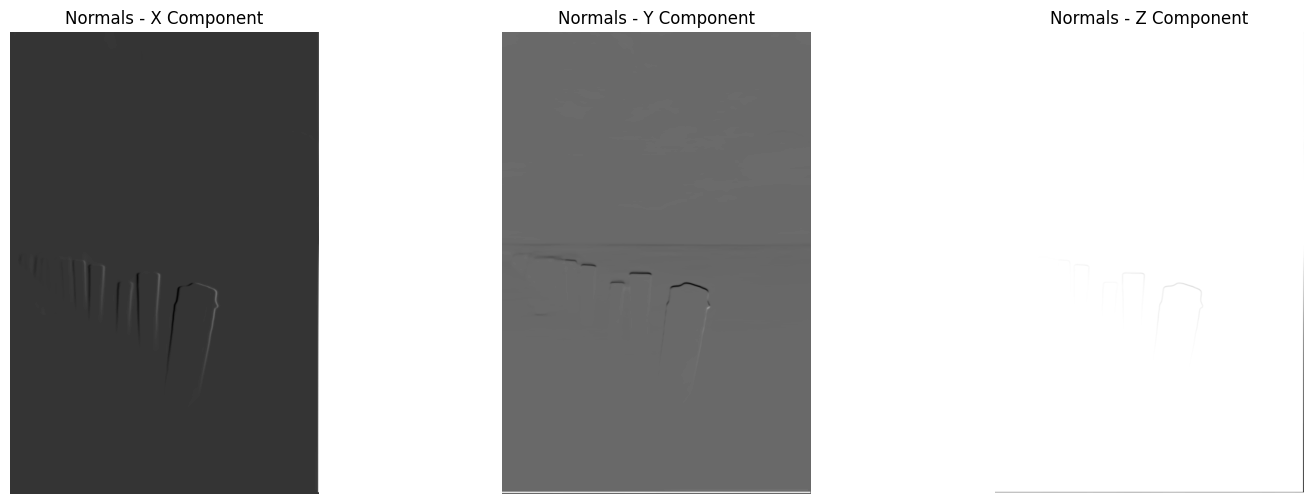

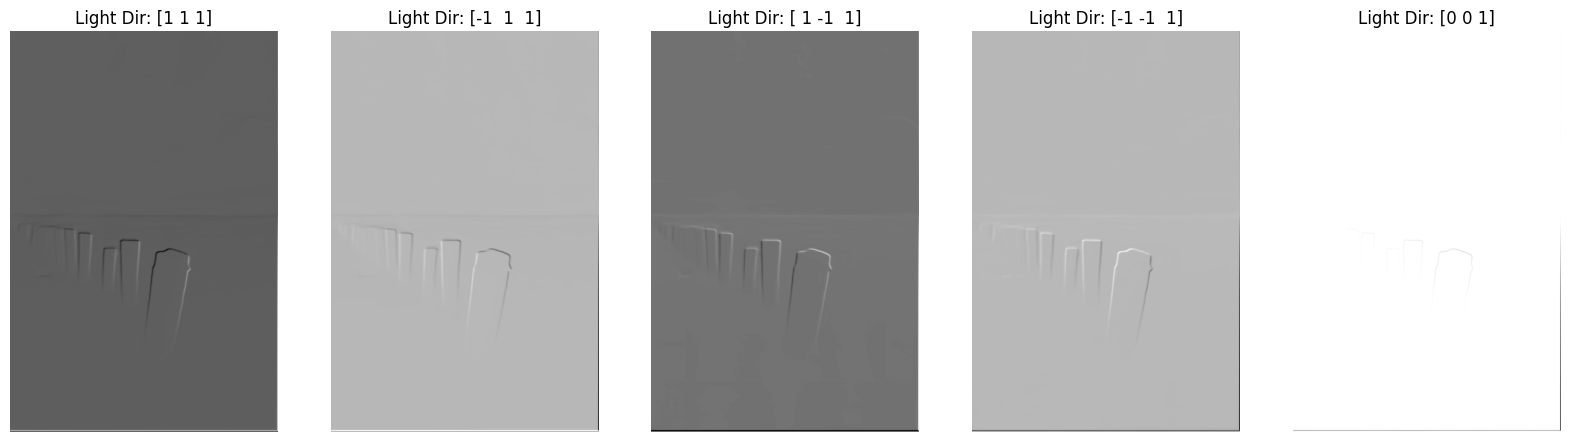

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load depth map
depth_map_path = "/content/drive/MyDrive/Capstone/SOBA-high-res/high_depth_maps/challenge-shadow07.png"
depth_map = Image.open(depth_map_path)
depth_map_np = np.array(depth_map, dtype=np.float32)
depth_map_np_rescaled = (depth_map_np - depth_map_np.min()) / (depth_map_np.max() - depth_map_np.min())

# Compute surface normals from depth map
def compute_normals_from_depth(depth_map):
    dzdx = np.gradient(depth_map, axis=1)
    dzdy = np.gradient(depth_map, axis=0)
    normals = np.dstack((-dzdx, -dzdy, np.ones_like(depth_map)))
    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= norm
    return normals

normals = compute_normals_from_depth(depth_map_np_rescaled)

# Visualize normals
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(normals[:, :, 0], cmap="gray")
ax[0].set_title("Normals - X Component")
ax[0].axis("off")

ax[1].imshow(normals[:, :, 1], cmap="gray")
ax[1].set_title("Normals - Y Component")
ax[1].axis("off")

ax[2].imshow(normals[:, :, 2], cmap="gray")
ax[2].set_title("Normals - Z Component")
ax[2].axis("off")

plt.show()

# Compute shading using Lambertian reflectance
def compute_shading(normals, light_direction):
    light_direction = light_direction / np.linalg.norm(light_direction)
    n_dot_l = np.maximum(0, np.sum(normals * light_direction, axis=2))
    return n_dot_l

light_directions = [
    np.array([1, 1, 1]),
    np.array([-1, 1, 1]),
    np.array([1, -1, 1]),
    np.array([-1, -1, 1]),
    np.array([0, 0, 1])
]

fig, ax = plt.subplots(1, len(light_directions), figsize=(20, 6))
for i, light_dir in enumerate(light_directions):
    shading_map = compute_shading(normals, light_dir)
    ax[i].imshow(shading_map, cmap="gray")
    ax[i].set_title(f"Light Dir: {light_dir}")
    ax[i].axis("off")

plt.show()

In [ ]:
# Not looking correct - need to keep experimenting with different models.